<a href="https://colab.research.google.com/github/Guilli12pm/ML_proj/blob/master/kNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning project: kNN

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()
tf.__version__

from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

import pathlib
import random
from statistics import mode, StatisticsError
import timeit

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

##Download the images

In [3]:
#https://github.com/Guilli12pm/ML_proj/raw/master/next_ite.tar.gz

data_root_orig = tf.keras.utils.get_file('new_pic',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/new_pic.tar.gz',
                                         untar=True)
data_root = pathlib.Path(data_root_orig)
for item in data_root.iterdir():
  print(item)

/root/.keras/datasets/new_pic/Guillaume_Loranchet
/root/.keras/datasets/new_pic/.DS_Store
/root/.keras/datasets/new_pic/Guillaume_Paya


In [4]:
data_root_orig_1 = tf.keras.utils.get_file('new_pic(1)',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/new_pic(1).tar.gz',
                                         untar=True)
data_root_1 = pathlib.Path(data_root_orig_1)
for item in data_root_1.iterdir():
  print(item)

/root/.keras/datasets/new_pic(1)/Miha_S
/root/.keras/datasets/new_pic(1)/.DS_Store


In [5]:
data_root_orig_2 = tf.keras.utils.get_file('new_pic(2)',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/new_pic(2).tar.gz',
                                         untar=True)
data_root_2 = pathlib.Path(data_root_orig_2)
for item in data_root_2.iterdir():
  print(item)

/root/.keras/datasets/new_pic(2)/.DS_Store
/root/.keras/datasets/new_pic(2)/Nicholas_S


In [6]:
data_root_orig_test = tf.keras.utils.get_file('next_ite',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/result.tar.gz',
                                         untar=True)
data_root_test = pathlib.Path(data_root_orig_test)
for item in data_root_test.iterdir():
  print(item)

/root/.keras/datasets/next_ite/Guillaume_Loranchet
/root/.keras/datasets/next_ite/Miha_S
/root/.keras/datasets/next_ite/.DS_Store
/root/.keras/datasets/next_ite/Guillaume_Paya
/root/.keras/datasets/next_ite/Abdel_R
/root/.keras/datasets/next_ite/Nicholas_S


##Inspect the dataset

In [0]:
all_image_paths_0 = list(data_root.glob('*/*'))
all_image_paths_1 = list(data_root_1.glob('*/*'))
all_image_paths_2 = list(data_root_2.glob('*/*'))

all_image_paths_train = all_image_paths_2 + all_image_paths_1 + all_image_paths_0

all_image_paths_train = [str(path) for path in all_image_paths_train]
random.shuffle(all_image_paths_train)

all_image_paths_test = list(data_root_test.glob('*/*'))

all_image_paths_test = [str(path) for path in all_image_paths_test]
random.shuffle(all_image_paths_test)

image_count_train = len(all_image_paths_train)

In [8]:
all_image_paths_train[:5]

['/root/.keras/datasets/new_pic(2)/Nicholas_S/Nicholas_51_sp_5_rot_clock_4.png',
 '/root/.keras/datasets/new_pic(1)/Miha_S/Miha_S_85_sharpened_2_2_rot_anty_1.png',
 '/root/.keras/datasets/new_pic/Guillaume_Loranchet/Guillaume_Loranchet_51_sp_5_rot_anty_2.png',
 '/root/.keras/datasets/new_pic(2)/Nicholas_S/Nicholas_62_sharpened_1_4_rot_anty_5.png',
 '/root/.keras/datasets/new_pic/Guillaume_Loranchet/Guillaume_Loranchet_58_sp_9.png']

In [9]:
all_image_paths_test[:5]

['/root/.keras/datasets/next_ite/Guillaume_Loranchet/Guillaume_Loranchet_159.png',
 '/root/.keras/datasets/next_ite/Guillaume_Loranchet/Guillaume_Loranchet_120.png',
 '/root/.keras/datasets/next_ite/Guillaume_Loranchet/Guillaume_Loranchet_111.png',
 '/root/.keras/datasets/next_ite/Nicholas_S/Nicholas_S_146.png',
 '/root/.keras/datasets/next_ite/Miha_S/Miha_S_112.png']

In [0]:
image_paths_test_abdel = []

for imag in all_image_paths_test:
  if 'Abdel_R' in imag:
    image_paths_test_abdel.append(imag)
    all_image_paths_test.remove(imag)
    

###Show images

Training images


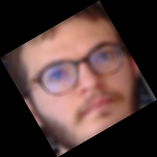

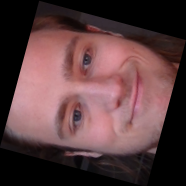


Testing images


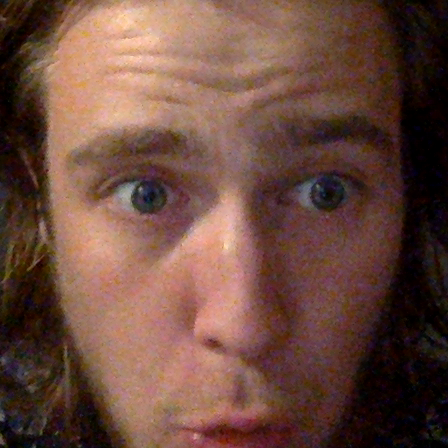

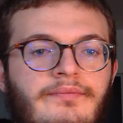

In [11]:
import IPython.display as display

print('Training images')
for n in range(2):
  image_path = random.choice(all_image_paths_train)
  #print('image path: ',image_path)
  display.display(display.Image(image_path))

print('\nTesting images')
for n in range(2):
  image_path = random.choice(all_image_paths_test)
  #print('image path: ',image_path)
  display.display(display.Image(image_path))

###Label images

In [12]:
label_names_0 = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names_1 = sorted(item.name for item in data_root_1.glob('*/') if item.is_dir())
label_names_2 = sorted(item.name for item in data_root_2.glob('*/') if item.is_dir())

label_names = label_names_0 + label_names_1 + label_names_2
label_names

['Guillaume_Loranchet', 'Guillaume_Paya', 'Miha_S', 'Nicholas_S']

In [13]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'Guillaume_Loranchet': 0, 'Guillaume_Paya': 1, 'Miha_S': 2, 'Nicholas_S': 3}

In [0]:
for name in label_names:
  stri = '/root/.keras/datasets/next_ite/' + name + '/.DS_Store'
  if stri in all_image_paths_test:
    all_image_paths_test.remove(stri)
  stri = '/root/.keras/datasets/next_ite/' + name + '/._.DS_Store'
  if stri in all_image_paths_test:
    all_image_paths_test.remove(stri)

In [15]:
all_image_labels_train = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths_train]

print("First 10 labels indices of training set: ", all_image_labels_train[:10])

all_image_labels_test = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths_test]

print("First 10 labels indices of training set: ", all_image_labels_test[:10])

First 10 labels indices of training set:  [3, 2, 0, 3, 0, 1, 0, 1, 3, 3]
First 10 labels indices of training set:  [0, 0, 0, 3, 2, 0, 3, 0, 3, 1]


###Load images with Tensor Flow

In [16]:
img_path = all_image_paths_train[0]
img_path

'/root/.keras/datasets/new_pic(2)/Nicholas_S/Nicholas_51_sp_5_rot_clock_4.png'

In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])

  return image

def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

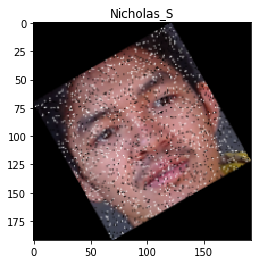

In [18]:
image_path = all_image_paths_train[0]
label = all_image_labels_train[0]

plt.imshow(load_and_preprocess_image(image_path)/255)
plt.grid(False)
#plt.xlabel(caption_image(img_path).encode('utf-8'))
plt.title(label_names[label].title())
print()

In [35]:
n_train = len(all_image_paths_train)

x_train_aux = [load_and_preprocess_image(all_image_paths_train[i]) for i in range(n_train)]
x_train_aux_2 = np.array([np.array(x_train_aux[i]) for i in range(n_train)])
x_train = x_train_aux_2 / 255   #normalize between 0 and 1

n_test = len(all_image_paths_test)

x_test_aux = [load_and_preprocess_image(all_image_paths_test[i]) for i in range(n_test)]
x_test_aux_2 = np.array([np.array(x_test_aux[i]) for i in range(n_test)])
x_test = x_test_aux_2 / 255   #normalize between 0 and 1
print(x_train.shape)
print(x_test.shape)

n_test_abdel = len(image_paths_test_abdel)

x_test_abdel_aux = [load_and_preprocess_image(image_paths_test_abdel[i]) for i in range(n_test_abdel)]
x_test_abdel_aux_2 = np.array([np.array(x_test_abdel_aux[i]) for i in range(n_test_abdel)])
x_test_abdel = x_test_abdel_aux_2 / 255   #normalize between 0 and 1
print(x_test_abdel.shape)

y_train = np.array([[0]*i + [1] + [0]*(len(label_names)-1-i) for i in all_image_labels_train])
y_test = np.array([[0]*i + [1] + [0]*(len(label_names)-1-i) for i in all_image_labels_test])
print(y_train.shape)
print(y_test.shape)

labels = label_names
print(labels)

print(y_train[0])

(4140, 192, 192, 3)
(177, 192, 192, 3)
(9, 192, 192, 3)
(4140, 4)
(177, 4)
['Guillaume_Loranchet', 'Guillaume_Paya', 'Miha_S', 'Nicholas_S']
[0 0 0 1]


(4140, 4)


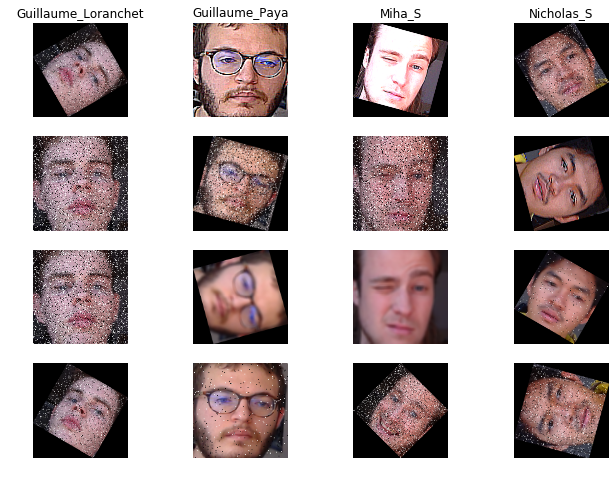

(177, 4)


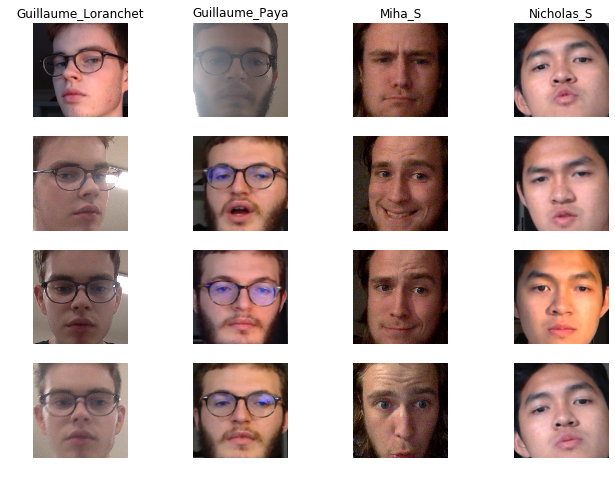

In [20]:
def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    f, axes = plt.subplots(n, len(categories[0]), figsize=(11,8))
    print(categories.shape)
    for i in range(len(categories[0])):
        count = 0
        j = 0
        while count < n and j < len(categories):
            #print(j,i)
            if categories[j][i] == 1:
                axes[count,i].imshow(images[j,:,:,:])
                axes[count,i].axis('off')
                if count == 0:
                    axes[count,i].set_title(labels[i])
                count += 1
            j += 1

    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

show_first_n_images_in_categories(4, x_train, y_train, labels)
show_first_n_images_in_categories(4, x_test, y_test, labels)

##kNN Model

In [21]:
def euclidean_distance(ima_1,ima_2):
  return np.sqrt(sum(sum(sum((ima_1-ima_2)**2))))

print(euclidean_distance(x_train[0],x_train[1]))

137.89181214078212


In [22]:
def test(ima_test,label):
  print(label)
  x1, x2, x3, x4 = [],[],[],[]
  for i in range(0,100):
    if y_train[i][0]:
      x1.append(euclidean_distance(ima_test,x_train[i]))
    elif y_train[i][1]:
      x2.append(euclidean_distance(ima_test,x_train[i]))
    elif y_train[i][2]:
      x3.append(euclidean_distance(ima_test,x_train[i]))
    elif y_train[i][3]:
      x4.append(euclidean_distance(ima_test,x_train[i]))

  liste = [np.mean(x1),np.mean(x2),np.mean(x3),np.mean(x4)]
  return liste

test(x_test[32],y_test[32])

[0 0 0 1]


[106.73304097132802, 105.07474600493268, 102.48326905115059, 107.4065601013141]

In [0]:
def average(liste):
  return sum(liste)/len(liste)

In [0]:
def clustering(x,y,k):
  nb_pers = len(y[0])  #4
  res = [[] for _ in range(nb_pers)]
  intermediate = [[] for _ in range(nb_pers)]
  
  for i in range(len(x)):
    for j in range(nb_pers):
      if len(intermediate[j]) == k:   #make groups of size k
        res[j].append(average(intermediate[j]))  
        intermediate[j] = []
    for j in range(nb_pers):
      if y[i][j]:   # i-th picture represent the j-th person in labels
        intermediate[j].append(x[i])
  for j in range(nb_pers):
    if len(intermediate[j]) != 0:
      res[j].append(average(intermediate[j])) 
  return res
        

A = clustering(x_train,y_train,100)

In [25]:
def try_mode(liste):
  '''check if there are more than 1 mode'''
  try:
    return mode(liste)
  except StatisticsError:
    return -1
  
B = [1,2,3]
try_mode(B)

-1

In [26]:
A = clustering(x_train,y_train,4)

def kNN(ima_input,A,k):  
  res_aux = {}
  for i in range(len(A)):
    for j in range(len(A[i])):
      res_aux[euclidean_distance(ima_input,A[i][j])] = i
        
  res = [value for (key,value) in sorted(res_aux.items())]   #take only the first k closest element
  #print(res)
  while try_mode(res[:k]) == -1:  #return the most frequent element
    k += 1
  return mode(res[:k])
  
  
def test_knn(x_test,y_test,A,k):
  '''output: accuracy'''
  res = 0
  for i in range(len(y_test)):
    val = kNN(x_test[i],A,k)
    if y_test[i][val]:
      res += 1
  return res/len(y_test)  

'''
for i in range(1,10):
  print(i)
  print(test_knn(x_test,y_test,A,i))
  print('')
'''

1
0.4576271186440678

2
0.632768361581921

3
0.632768361581921

4
0.6440677966101694

5
0.6610169491525424

6
0.6497175141242938

7
0.6384180790960452

8
0.6101694915254238

9
0.5932203389830508



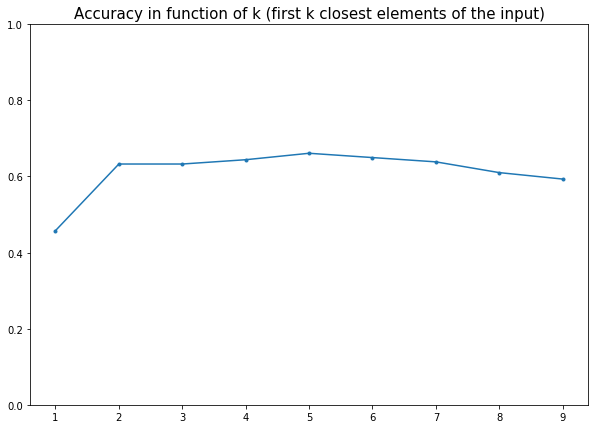

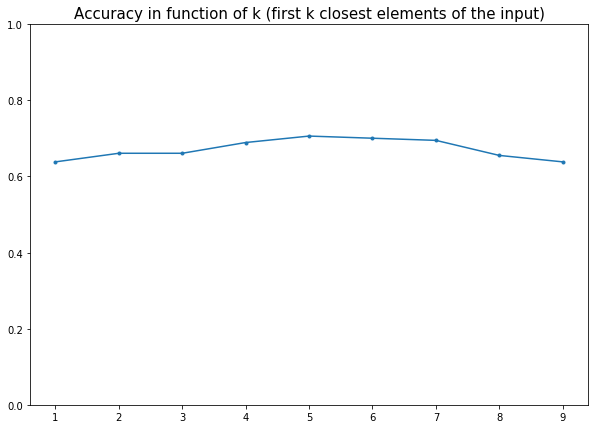

In [29]:
A = [0.4576271186440678, 0.632768361581921,0.632768361581921 ,0.6440677966101694 , 0.6610169491525424, 0.6497175141242938, 0.6384180790960452,0.6101694915254238 , 0.5932203389830508]
C = [i for i in range(1,10)]

plt.figure(figsize=(10,7))
plt.plot(C,A,marker='.')
plt.title('Accuracy in function of k (first k closest elements of the input)',fontsize=15)
plt.ylim([0,1])
plt.show()

A = [0.6384180790960452, 0.6610169491525424, 0.6610169491525424, 0.6892655367231638, 0.7062146892655368, 0.7005649717514124, 0.6949152542372882, 0.655367231638418, 0.6384180790960452]
C = [i for i in range(1,10)]

plt.figure(figsize=(10,7))
plt.plot(C,A,marker='.')
plt.title('Accuracy in function of k (first k closest elements of the input)',fontsize=15)
plt.ylim([0,1])
plt.show()

In [30]:
n = len(y_test)

def test_plot(liste = [1,2,3,4,5,6,7,8,10,12,15]):
  for i in liste:
    A = clustering(x_train,y_train,i)
    def test_time():
      print('Cluster of {} elements'.format(i))
      print('Accuracy: ',test_knn(x_test,y_test,A,5))

    print('Time to predict each picture',timeit.timeit(test_time,number=1)/n,'\n')
    
#test_plot()

def test_plot_v2(x_train,y_train,x_test,y_test,liste,k):
  res = [0 for _ in range(len(liste))]
  j = 0
  for i in liste:
    A = clustering(x_train,y_train,i)
    accuracy = test_knn(x_test,y_test,A,k)
    res[j] = accuracy
    j += 1
  return res

Cluster of 1 elements
Accuracy:  0.4519774011299435
Time to predict each picture 1.9556941677344652 

Cluster of 2 elements
Accuracy:  0.5988700564971752
Time to predict each picture 0.9695916148757019 

Cluster of 3 elements
Accuracy:  0.6779661016949152
Time to predict each picture 0.6562474537514149 

Cluster of 4 elements
Accuracy:  0.6610169491525424
Time to predict each picture 0.48557390805649575 

Cluster of 5 elements
Accuracy:  0.6045197740112994
Time to predict each picture 0.3847716027118679 

Cluster of 6 elements
Accuracy:  0.5536723163841808
Time to predict each picture 0.32295399453672524 

Cluster of 7 elements
Accuracy:  0.519774011299435
Time to predict each picture 0.27883983207344387 

Cluster of 8 elements
Accuracy:  0.5310734463276836
Time to predict each picture 0.24320527823164087 

Cluster of 10 elements
Accuracy:  0.6666666666666666
Time to predict each picture 0.1919944706892675 

Cluster of 12 elements
Accuracy:  0.5141242937853108
Time to predict each pict

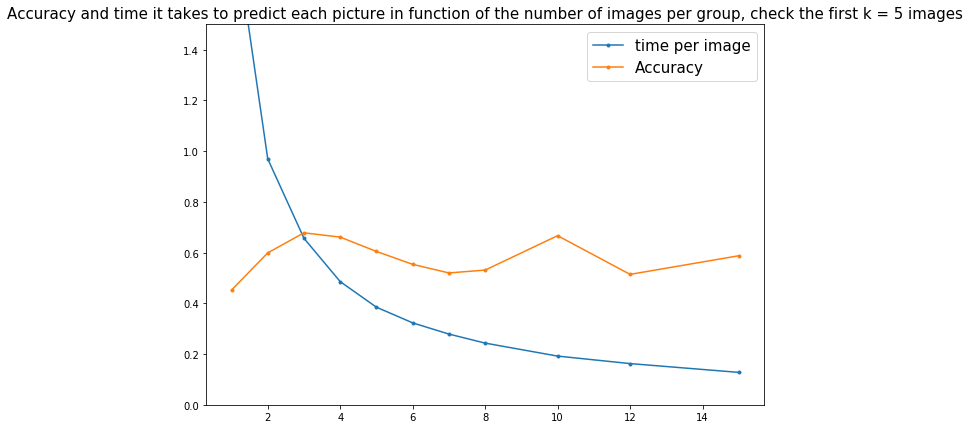

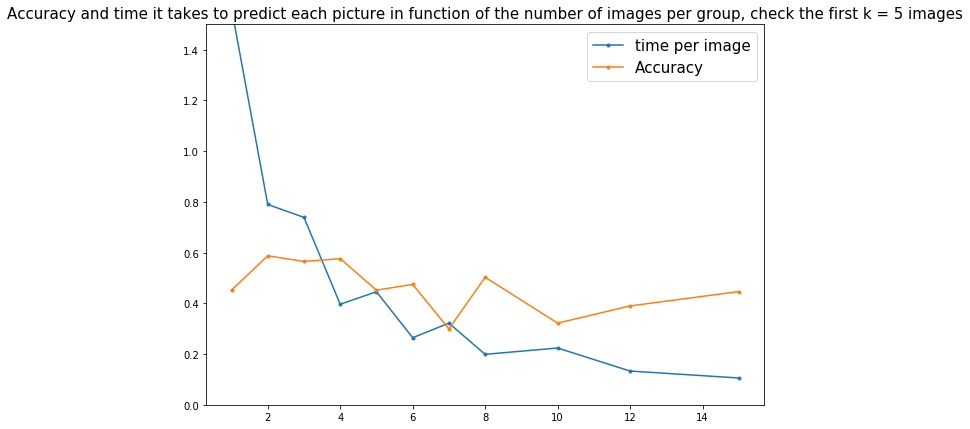

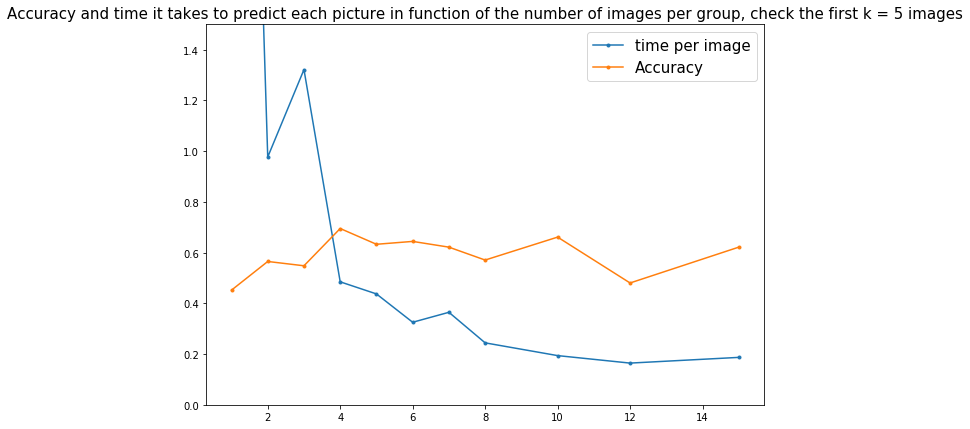

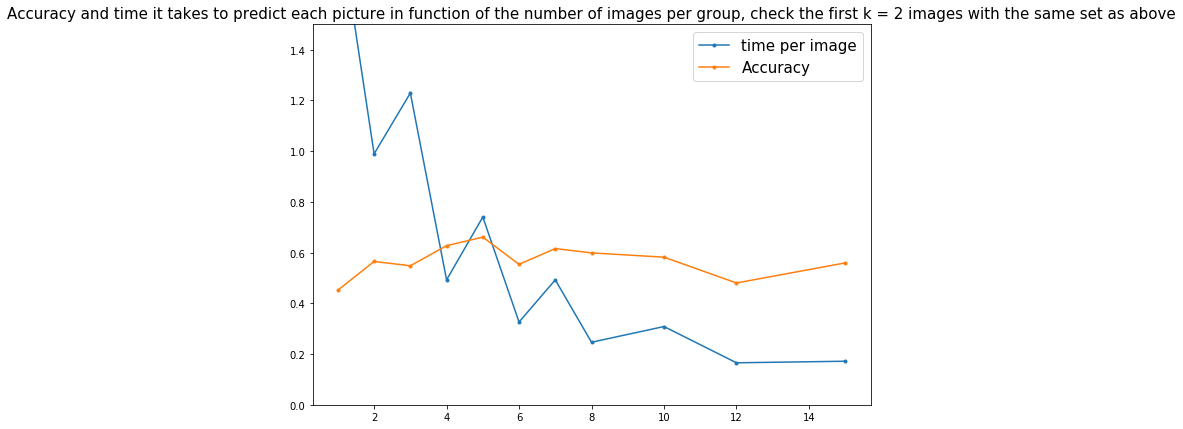

In [32]:
A = [1.9556941677344652,0.9695916148757019,0.6562474537514149,0.48557390805649575,0.3847716027118679,0.32295399453672524,0.27883983207344387,0.24320527823164087, 0.1919944706892675 ,0.16246278505084485  , 0.12778141203954752 ]
B = [0.4519774011299435,0.5988700564971752,0.6779661016949152,0.6610169491525424,0.6045197740112994,0.5536723163841808 ,0.519774011299435,0.5310734463276836 ,0.6666666666666666 ,0.5141242937853108 , 0.5875706214689266]
C = [i for i in range(1,9)]+[10,12,15]

plt.figure(figsize=(10,7))
#plt.plot(A[0],B[0])
plt.plot(C,A,marker='.')
plt.plot(C,B,marker='.')
plt.title('Accuracy and time it takes to predict each picture in function of the number of images per group, check the first k = 5 images',fontsize=15)
plt.legend(('time per image','Accuracy'),loc='best',fontsize=15)
plt.ylim([0,1.5])
plt.show()

A = [1.5631840424519776,0.7896613351468931 ,0.7388307934406788 , 0.3963731183954804 ,0.4456509903672313 ,0.26446220867796655 ,0.3217400533559327 ,0.1989596205762712 ,0.2238477530395486 ,0.13305251205649724 ,0.10575665348587636 ]
B = [0.4519774011299435,0.5875706214689266,0.5649717514124294,0.576271186440678,0.4519774011299435,0.4745762711864407,0.2994350282485876,0.5028248587570622,0.3220338983050847,0.3898305084745763,0.4463276836158192]
C = [i for i in range(1,9)]+[10,12,15]

plt.figure(figsize=(10,7))
#plt.plot(A[0],B[0])
plt.plot(C,A,marker='.')
plt.plot(C,B,marker='.')
plt.title('Accuracy and time it takes to predict each picture in function of the number of images per group, check the first k = 5 images',fontsize=15)
plt.legend(('time per image','Accuracy'),loc='best',fontsize=15)
plt.ylim([0,1.5])
plt.show()

A = [5.509470149999999,0.9767672461638421 ,1.3214222332033896 ,0.4847251269265539 ,0.43708202742372726 ,0.32536828557627134 ,0.3646449667118636 ,0.2441796150169492 ,0.1939253001242925 ,0.1643949571977422 ,0.18692199483615757 ]
B = [0.4519774011299435,0.5649717514124294,0.5480225988700564,0.6949152542372882,0.632768361581921,0.6440677966101694,0.6214689265536724,0.5706214689265536,0.6610169491525424,0.480225988700565,0.6214689265536724]
C = [i for i in range(1,9)]+[10,12,15]

plt.figure(figsize=(10,7))
#plt.plot(A[0],B[0])
plt.plot(C,A,marker='.')
plt.plot(C,B,marker='.')
plt.title('Accuracy and time it takes to predict each picture in function of the number of images per group, check the first k = 5 images',fontsize=15)
plt.legend(('time per image','Accuracy'),loc='best',fontsize=15)
plt.ylim([0,1.5])
plt.show()

A = [1.9345539544124293,0.9893024473559323,1.2290385608757062,0.4926231926723159 ,0.7401058078813552,0.326265965728814,0.49248329315819217,0.24658806461581925,0.30851309332768395,0.16557568342372855,0.17173665325988668]
B = [0.4519774011299435,0.5649717514124294,0.5480225988700564,0.6271186440677966,0.6610169491525424,0.5536723163841808,0.615819209039548,0.5988700564971752,0.5819209039548022,0.480225988700565,0.559322033898305]
C = [i for i in range(1,9)]+[10,12,15]

plt.figure(figsize=(10,7))
#plt.plot(A[0],B[0])
plt.plot(C,A,marker='.')
plt.plot(C,B,marker='.')
plt.title('Accuracy and time it takes to predict each picture in function of the number of images per group, check the first k = 2 images with the same set as above',fontsize=15)
plt.legend(('time per image','Accuracy'),loc='best',fontsize=15)
plt.ylim([0,1.5])
plt.show()

In [33]:
def test_average_accuracy(k):
  print(all_image_paths_train[:3])
  random.shuffle(all_image_paths_train)
  print(all_image_paths_train[:3],'\n')

  random.shuffle(all_image_paths_test)
  
  all_image_labels_train = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths_train]

  all_image_labels_test = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths_test]
  
  n_train = len(all_image_paths_train)

  x_train_aux = [load_and_preprocess_image(all_image_paths_train[i]) for i in range(n_train)]
  x_train_aux_2 = np.array([np.array(x_train_aux[i]) for i in range(n_train)])
  x_train = x_train_aux_2 / 255   #normalize between 0 and 1

  n_test = len(all_image_paths_test)

  x_test_aux = [load_and_preprocess_image(all_image_paths_test[i]) for i in range(n_test)]
  x_test_aux_2 = np.array([np.array(x_test_aux[i]) for i in range(n_test)])
  x_test = x_test_aux_2 / 255   #normalize between 0 and 1

  y_train = np.array([[0]*i + [1] + [0]*(len(label_names)-1-i) for i in all_image_labels_train])
  y_test = np.array([[0]*i + [1] + [0]*(len(label_names)-1-i) for i in all_image_labels_test])

  accuracy = test_plot_v2(x_train,y_train,x_test,y_test,[3,4,5],k)
  
  return accuracy

n = 3
k = 5
accu= [] 

for _ in range(n):
  accu.append(test_average_accuracy(k))
  
print(accu)

['/root/.keras/datasets/new_pic(2)/Nicholas_S/Nicholas_51_sp_5_rot_clock_4.png', '/root/.keras/datasets/new_pic(1)/Miha_S/Miha_S_85_sharpened_2_2_rot_anty_1.png', '/root/.keras/datasets/new_pic/Guillaume_Loranchet/Guillaume_Loranchet_51_sp_5_rot_anty_2.png']
['/root/.keras/datasets/new_pic/Guillaume_Loranchet/Guillaume_Loranchet_4_sp_3_rot_clock_2.png', '/root/.keras/datasets/new_pic(1)/Miha_S/Miha_S_53_sp_5_rot_clock_1.png', '/root/.keras/datasets/new_pic/Guillaume_Paya/Guillaume_Paya_50_sp_7_rot_clock_2.png']
['/root/.keras/datasets/new_pic/Guillaume_Loranchet/Guillaume_Loranchet_4_sp_3_rot_clock_2.png', '/root/.keras/datasets/new_pic(1)/Miha_S/Miha_S_53_sp_5_rot_clock_1.png', '/root/.keras/datasets/new_pic/Guillaume_Paya/Guillaume_Paya_50_sp_7_rot_clock_2.png']
['/root/.keras/datasets/new_pic/Guillaume_Paya/Guillaume_Paya_94.png', '/root/.keras/datasets/new_pic/Guillaume_Loranchet/Guillaume_Loranchet_88_blurred_2_rot_clock_2.png', '/root/.keras/datasets/new_pic(2)/Nicholas_S/Nichola

In [0]:
print("Average accuracy for clusters of size 4: ", (0.6892655367231638 + 0.6892655367231638 + 0.6892655367231638)/3)
print("Average accuracy for clusters of size 5: ", (0.5536723163841808 + 0.5536723163841808 + 0.5536723163841808)/3)

In [0]:
x_test_abdel
